## Import Libraries

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Input,Flatten,Dense,Dropout
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image_dataset_from_directory
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import string
import seaborn as sns
import pickle
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-09-04 13:37:48.256923: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-04 13:37:48.257041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-04 13:37:48.426598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Create training and testing datasets from directories

In [2]:
train_ds = image_dataset_from_directory(
    directory = '/kaggle/input/handwritten-english-characters-and-digits/augmented_images/augmented_images1',
    labels = 'inferred',
    label_mode = 'int',
    image_size = (256, 256),
    shuffle = True
)

test_ds1 = image_dataset_from_directory(
    directory = '/kaggle/input/handwritten-english-characters-and-digits/handwritten-english-characters-and-digits/combined_folder/train',
    labels = 'inferred',
    label_mode = 'int',
    image_size = (256, 256),
    shuffle = True
)

test_ds2 = image_dataset_from_directory(
    directory = '/kaggle/input/handwritten-english-characters-and-digits/handwritten-english-characters-and-digits/combined_folder/test',
    labels = 'inferred',
    label_mode = 'int',
    image_size = (256, 256),
    shuffle = True
)

test_ds = test_ds1.concatenate(test_ds2)

Found 13640 files belonging to 62 classes.
Found 2728 files belonging to 62 classes.
Found 682 files belonging to 62 classes.


## VGG19 Model for Transfer Learning

In [3]:
conv_base = VGG19(
    weights = 'imagenet',
    include_top = False,
    input_shape = (256, 256, 3)
)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Freeze weights

In [4]:
conv_base.trainable = False

In [5]:
conv_base.summary()

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 256, 256, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 256, 256, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 128, 128, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 128, 128, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 64, 64, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 64, 64, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 32, 32, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 32, 32, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 16, 16, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

## Add Fully Connected Layers

In [6]:
model = Sequential()
model.add(Input(shape=(256,256,3)))
model.add(conv_base)
model.add(Flatten())
model.add(Dense(224,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(416,activation='sigmoid'))
model.add(Dropout(0.1))
model.add(Dense(62,activation='softmax'))

In [7]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)              │ (None, 8, 8, 512)      │    20,024,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 224)            │     7,340,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 416)            │        93,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 416)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 62)             │        25,854 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,484,094 (104.84 MB)

 Trainable params: 7,459,710 (28.46 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [8]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='sgd',metrics=['accuracy'])

## Model Training

In [9]:
history = model.fit(train_ds, epochs=15, validation_data=test_ds)

Epoch 1/15
  1/427 ━━━━━━━━━━━━━━━━━━━━ 5:08:36 43s/step - accuracy: 0.0312 - loss: 4.3817

I0000 00:00:1725457131.075252      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1725457131.102139      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.1791 - loss: 3.5265

W0000 00:00:1725457215.802689      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725457217.181995      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725457231.796165      78 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


427/427 ━━━━━━━━━━━━━━━━━━━━ 165s 285ms/step - accuracy: 0.1794 - loss: 3.5252 - val_accuracy: 0.7062 - val_loss: 1.6732
Epoch 2/15


W0000 00:00:1725457252.725727      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


427/427 ━━━━━━━━━━━━━━━━━━━━ 89s 209ms/step - accuracy: 0.6184 - loss: 1.7979 - val_accuracy: 0.8305 - val_loss: 0.8895
Epoch 3/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 90s 211ms/step - accuracy: 0.7706 - loss: 1.0964 - val_accuracy: 0.8422 - val_loss: 0.7181
Epoch 4/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 92s 216ms/step - accuracy: 0.8366 - loss: 0.7671 - val_accuracy: 0.8762 - val_loss: 0.4967
Epoch 5/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 142s 216ms/step - accuracy: 0.8813 - loss: 0.5629 - val_accuracy: 0.8850 - val_loss: 0.4190
Epoch 6/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 142s 216ms/step - accuracy: 0.9057 - loss: 0.4378 - val_accuracy: 0.8959 - val_loss: 0.3629
Epoch 7/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 92s 215ms/step - accuracy: 0.9259 - loss: 0.3540 - val_accuracy: 0.8918 - val_loss: 0.3547
Epoch 8/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 92s 216ms/step - accuracy: 0.9404 - loss: 0.2941 - val_accuracy: 0.9023 - val_loss: 0.3290
Epoch 9/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 142s 216ms/step - accuracy: 0.9488 - loss: 0.2491 - 

## Accuracy Curve

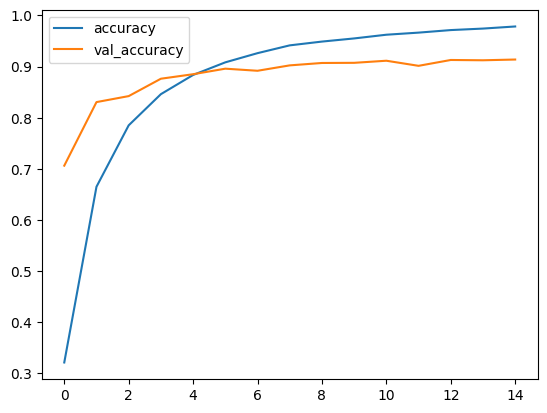

In [10]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

## Loss Curve

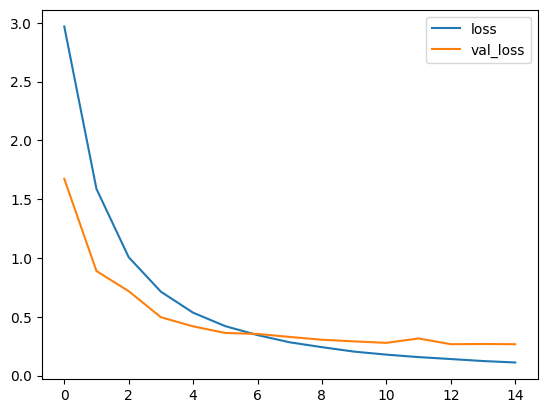

In [11]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Evaluation on training data

In [12]:
loss, accuracy = model.evaluate(train_ds)
print("Loss:", loss)
print("Accuracy:",accuracy)

427/427 ━━━━━━━━━━━━━━━━━━━━ 73s 170ms/step - accuracy: 0.9819 - loss: 0.0726
Loss: 0.07091176509857178
Accuracy: 0.9834311008453369


## Evaluation on testing data

In [13]:
loss, accuracy = model.evaluate(test_ds)
print("Loss:",loss)
print("Accuracy:",accuracy)

108/108 ━━━━━━━━━━━━━━━━━━━━ 18s 168ms/step - accuracy: 0.9265 - loss: 0.2339
Loss: 0.2671976089477539
Accuracy: 0.9137830138206482


## Plotting Predictions 

In [14]:
def plot_predictions(generator, model):
    # Retrieve a batch of images and true labels from the generator
    images, true_labels = next(iter(generator))

    # Extract class names from the generator
    digits = [str(i) for i in range(10)]
    uppercase = [i for i in string.ascii_uppercase]
    lowercase = [i for i in string.ascii_lowercase]
    class_names = digits + uppercase + lowercase

    # Convert TensorFlow tensors to NumPy arrays if necessary
    if isinstance(true_labels, tensorflow.Tensor):
        true_labels = true_labels.numpy()
    if isinstance(images, tensorflow.Tensor):
        images = images.numpy()

    # Convert true_labels to class indices if they are one-hot encoded
    if true_labels.ndim > 1 and true_labels.shape[1] > 1:
        true_labels = np.argmax(true_labels, axis=1)

    # Ensure true_labels are integers
    true_labels = true_labels.astype(int)

    # Make predictions on the batch of images
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1).astype(int)

    # Check dimensions and types
    print(f'Images shape: {images.shape}')
    print(f'True labels shape: {true_labels.shape}, dtype: {true_labels.dtype}')
    print(f'Predicted classes shape: {predicted_classes.shape}, dtype: {predicted_classes.dtype}')

    # Set up the plot
    num_images = len(images)
    print(f'Number of images: {num_images}')

    # Calculate the number of rows needed
    num_cols = 6
    num_rows = int(np.ceil(num_images / num_cols))

    # Create subplots
    fig, axes = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(20, 5 * num_rows))

    # Flatten axes array for easy iteration
    axes = axes.flatten()

    for i in range(num_images):
        ax = axes[i]
        img = images[i]
        true_label_index = true_labels[i]
        predicted_label_index = predicted_classes[i]

        # Rescale the image if it was scaled during preprocessing
        img = img.astype(np.uint8)

        # Plot the image
        ax.imshow(img)
        ax.axis('off')

        # Get class names
        true_label_name = class_names[true_label_index]
        predicted_label_name = class_names[predicted_label_index]

        # Display true and predicted class names as text
        ax.set_title(f'True: {true_label_name}\nPred: {predicted_label_name}')

    # Hide any unused subplots
    for j in range(num_images, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 771ms/step


W0000 00:00:1725458986.918076      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Images shape: (32, 256, 256, 3)
True labels shape: (32,), dtype: int64
Predicted classes shape: (32,), dtype: int64
Number of images: 32


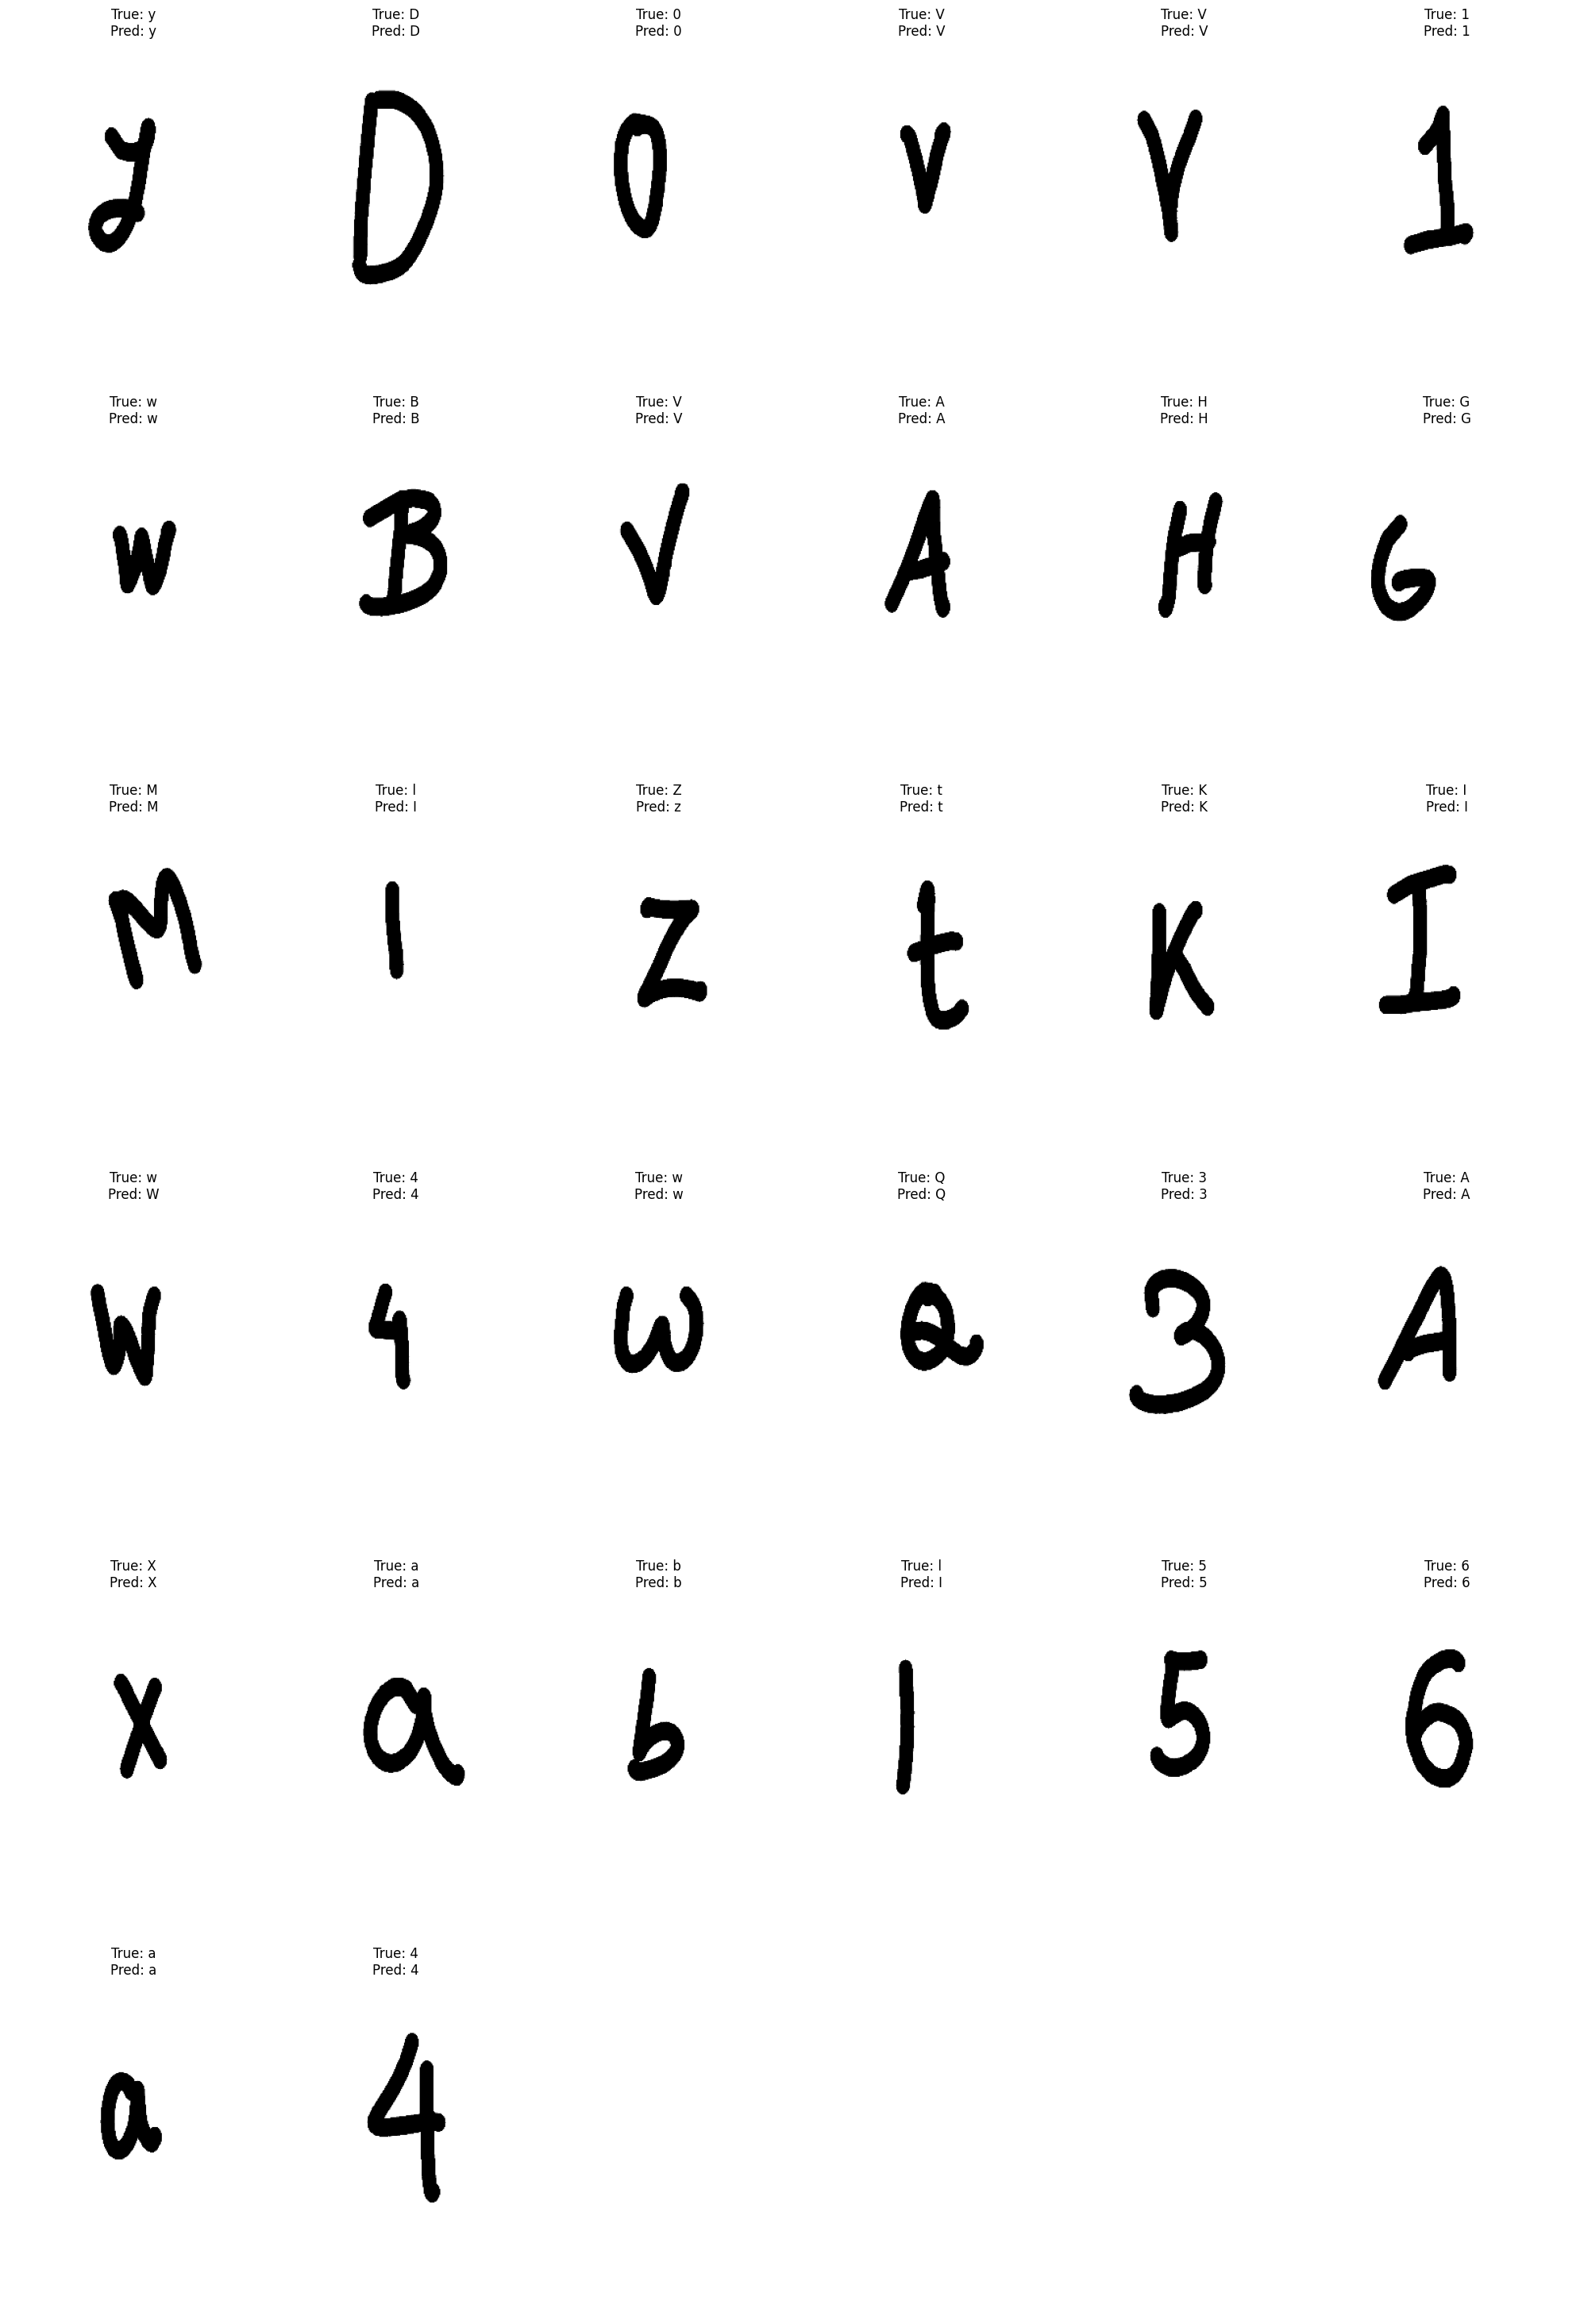

In [15]:
plot_predictions(test_ds, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Images shape: (32, 256, 256, 3)
True labels shape: (32,), dtype: int64
Predicted classes shape: (32,), dtype: int64
Number of images: 32


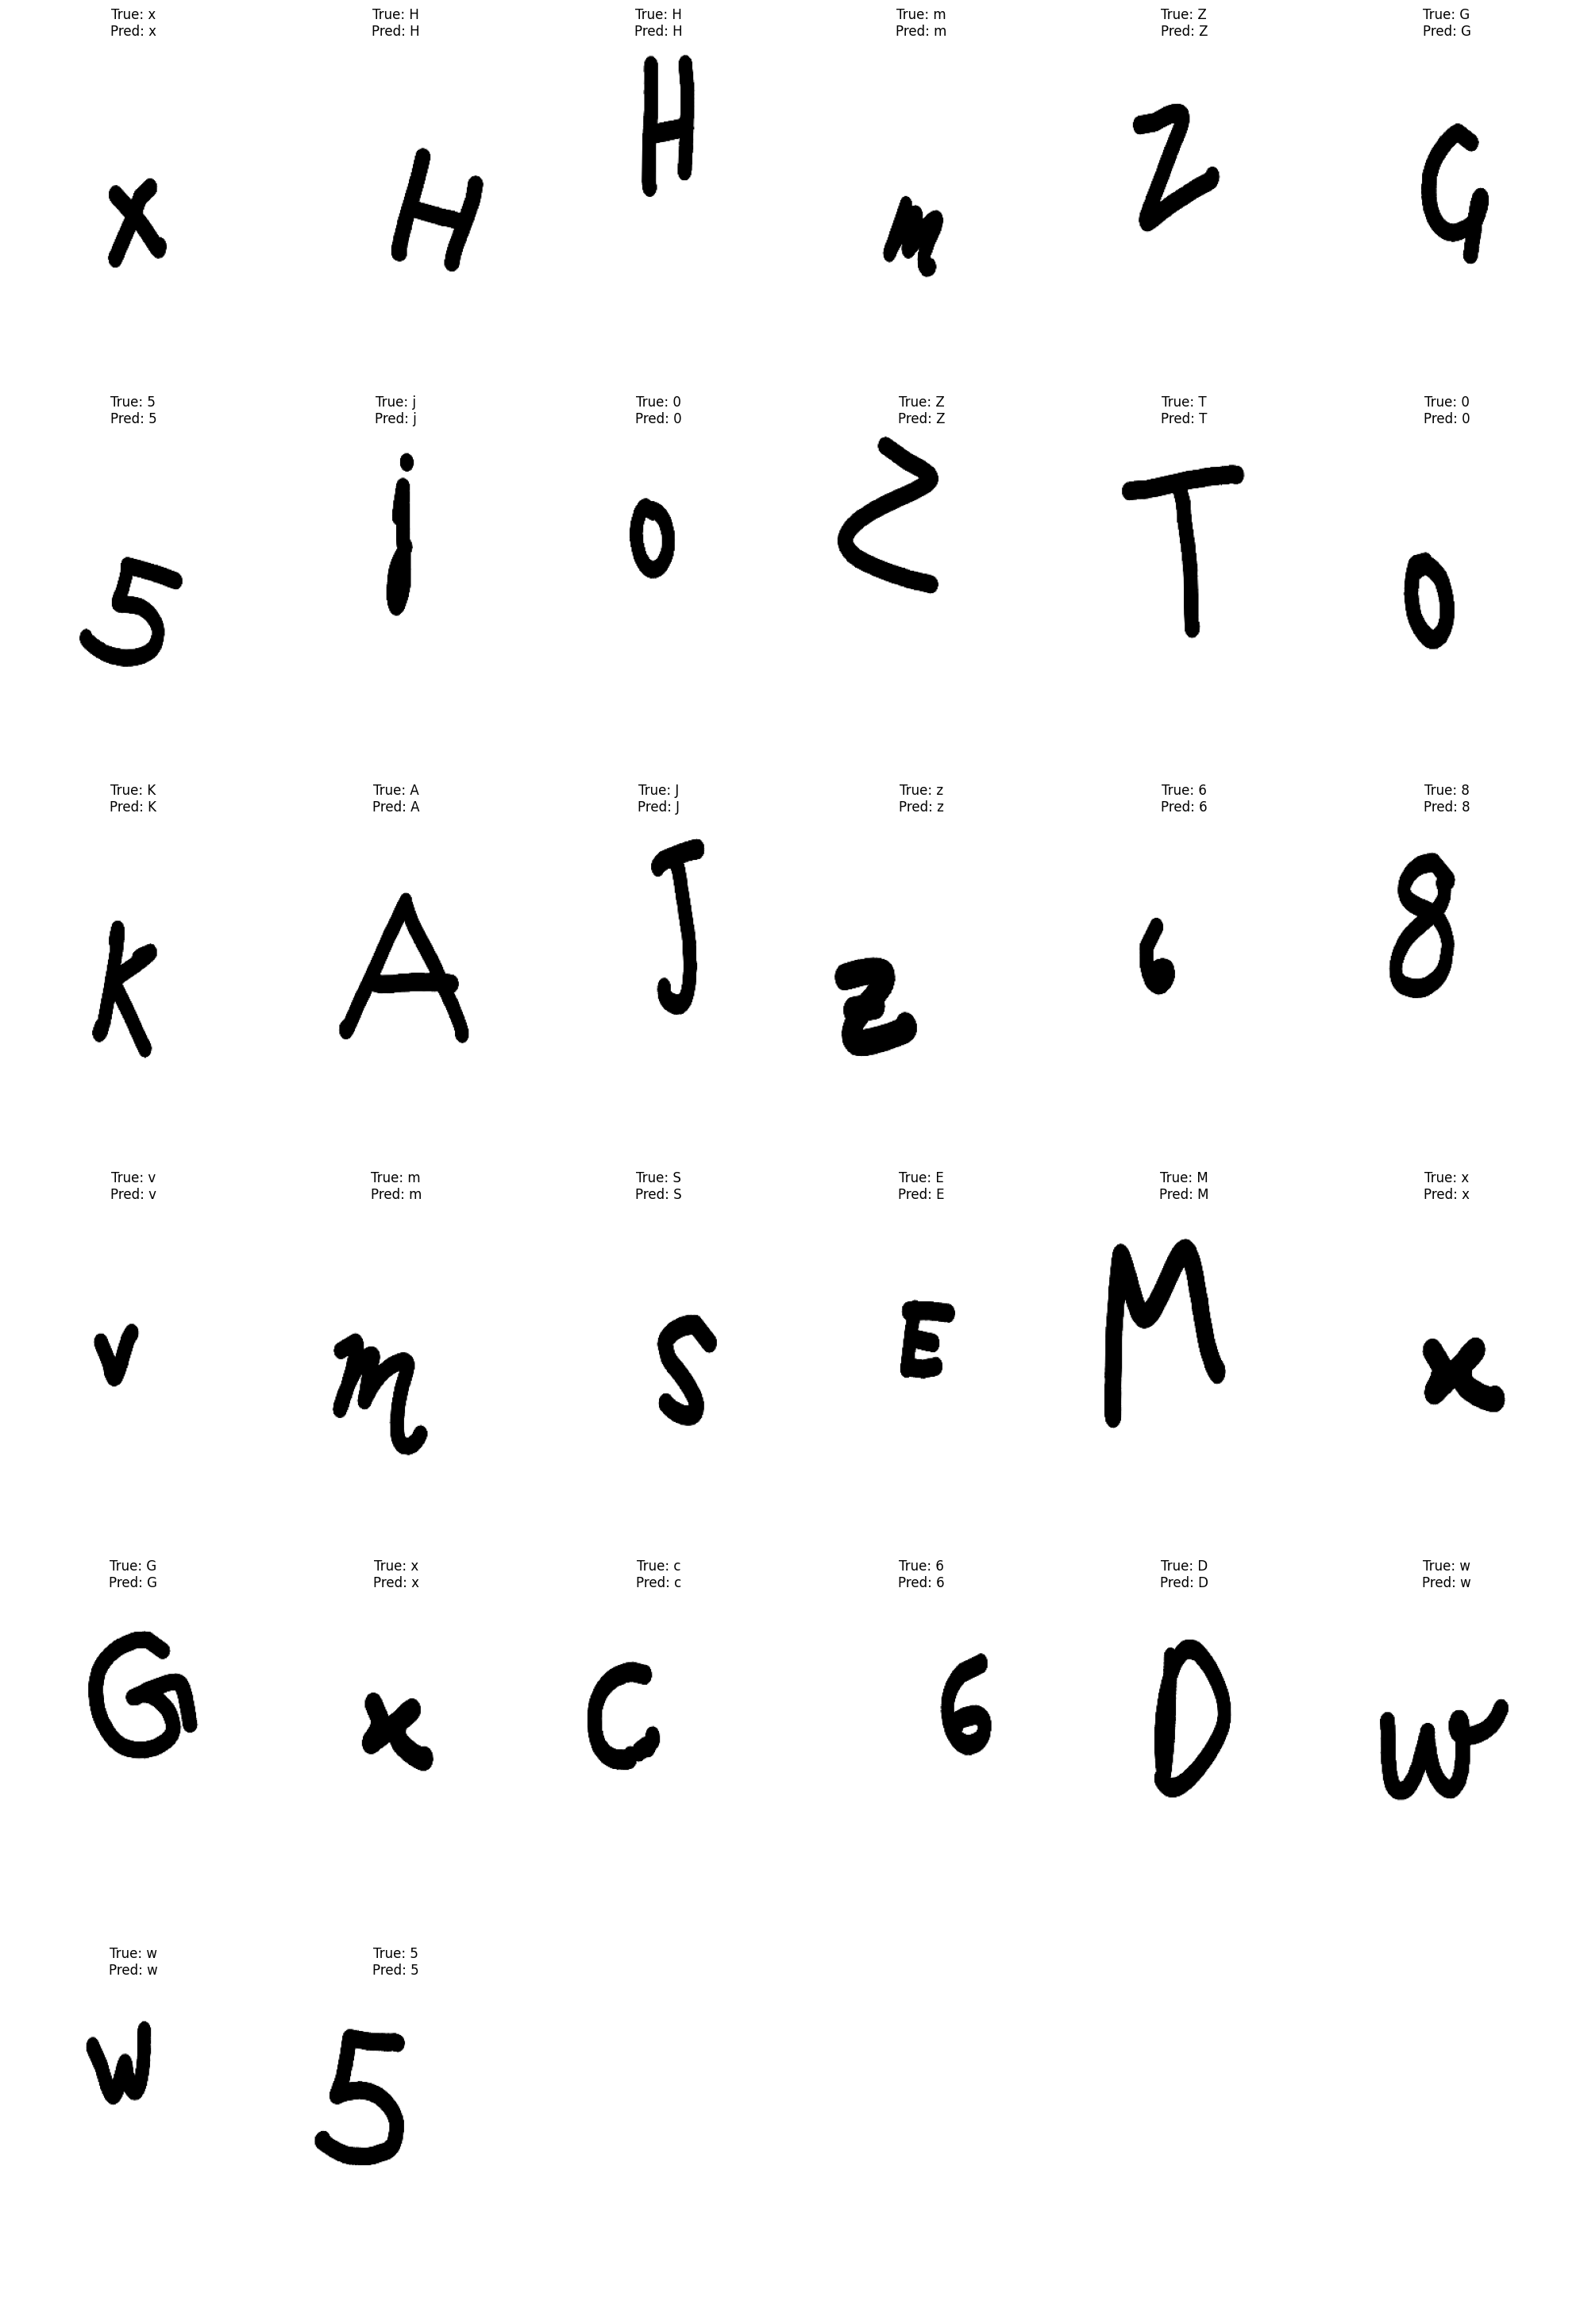

In [16]:
plot_predictions(train_ds, model)

In [17]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

W0000 00:00:1725459018.795118      80 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step


W0000 00:00:1725459024.307172      79 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


## Confusion Matrix

In [18]:
cm = confusion_matrix(y_true, y_pred)

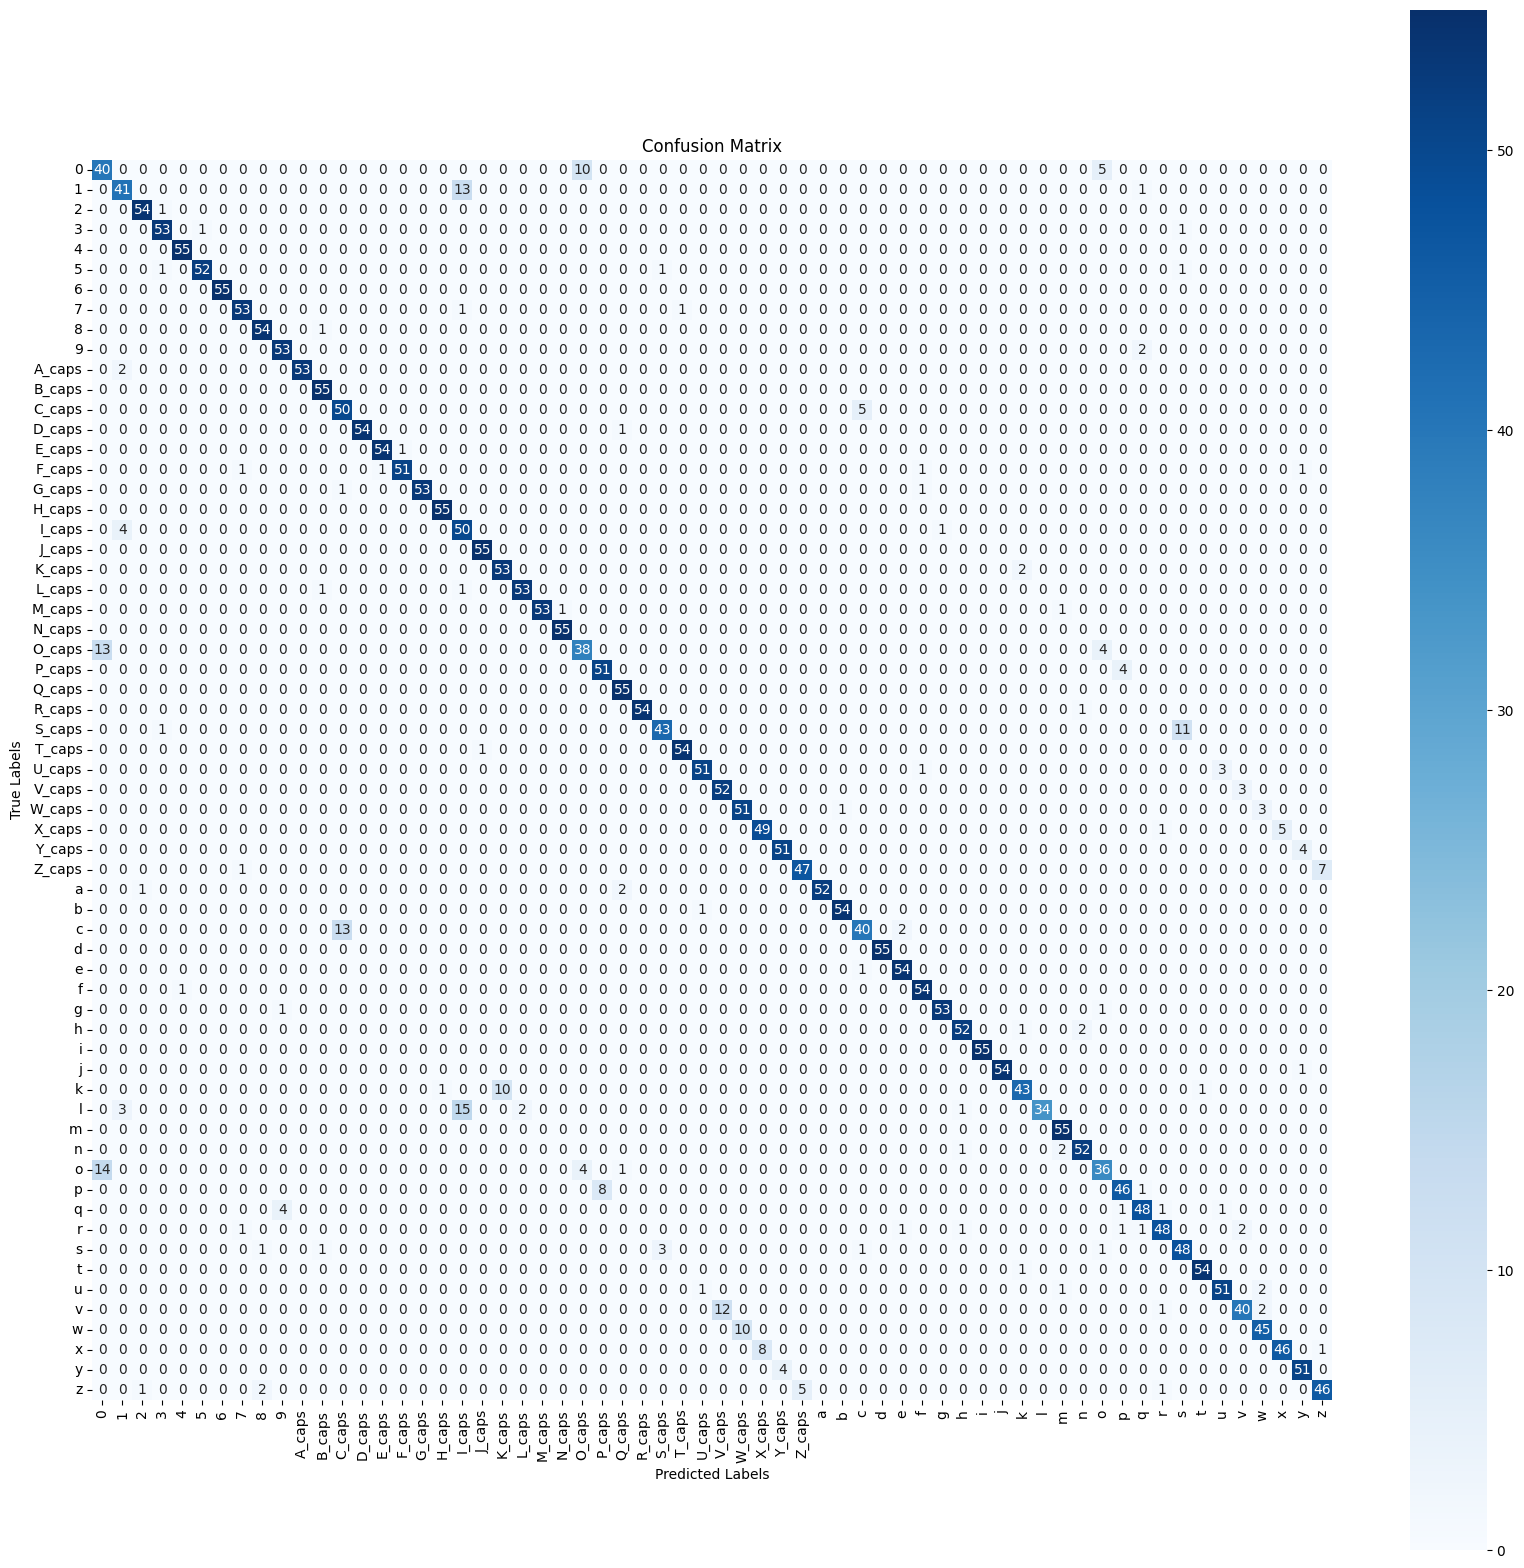

In [19]:
class_names = train_ds.class_names
num_classes = len(np.unique(y_true))
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(20, 20))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', cbar=True, square=True, 
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()